In [3]:
# %%
import warnings
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import statsmodels.api as sm
from dowhy import CausalModel

warnings.filterwarnings("ignore")

In [4]:
# %%
# Load the data
data = pd.read_csv("./data/simpsons_paradox_covid.csv")

In [5]:
# %%
# Calculate a naive effect of vaccination on death
prob_death_vaccinated = data[(data["outcome"] == "death") & (
    data["vaccine_status"] == "vaccinated")].shape[0] / data[
        data["vaccine_status"] == "vaccinated"].shape[0]
prob_death_unvaccinated = data[(data["outcome"] == "death") & (
    data["vaccine_status"] == "unvaccinated")].shape[0] / data[
        data["vaccine_status"] == "unvaccinated"].shape[0]
naive_effect = prob_death_vaccinated - prob_death_unvaccinated

print(f"P(D=1|V=1) = {prob_death_vaccinated: .4%}\n",
      f"P(D=1|V=0) = {prob_death_unvaccinated: .4%}\n",
      f"Naive effect of vaccination is: {naive_effect * 100} p.p.",
      sep="")

P(D=1|V=1) =  0.4107%
P(D=1|V=0) =  0.1675%
Naive effect of vaccination is: 0.24321894171585542 p.p.


 Calculate an effect of vaccination on death withing age groups

In [6]:
# %%
# Probability of death conditional on being vaccinated and under 50
prob_death_vaccinated_under50 = data.query(
    "outcome == 'death' & \
    vaccine_status == 'vaccinated' & \
    age_group == 'under 50'").shape[0] / data.query(
        "vaccine_status == 'vaccinated' & age_group == 'under 50'").shape[0]
# Probability of death conditional on being vaccinated and over 50
prob_death_vaccinated_over50 = data.query(
    "outcome == 'death' & \
    vaccine_status == 'vaccinated' & \
    age_group == '50 +'").shape[0] / data.query(
        "vaccine_status == 'vaccinated' & age_group == '50 +'").shape[0]
# Probability of death conditional on being unvaccinated and under 50
prob_death_unvaccinated_under50 = data.query(
    "outcome == 'death' & \
    vaccine_status == 'unvaccinated' & \
    age_group == 'under 50'").shape[0] / data.query(
        "vaccine_status == 'unvaccinated' & age_group == 'under 50'"
        ).shape[0]
# Probability of death conditional on being vaccinated and over 50
prob_death_unvaccinated_over50 = data.query(
    "outcome == 'death' & \
    vaccine_status == 'unvaccinated' & \
    age_group == '50 +'").shape[0] / data.query(
        "vaccine_status == 'unvaccinated' & age_group == '50 +'").shape[0]

print(f"P(D=1|V=1, Age < 50) - P(D=1|V=0, Age < 50) = {
    (prob_death_vaccinated_under50 - prob_death_unvaccinated_under50)
    * 100} p.p.",
      f"P(D=1|V=1, Age >= 50) - P(D=1|V=0, Age >= 50) = {
          (prob_death_vaccinated_over50 - prob_death_unvaccinated_over50)
          * 100} p.p.",
      sep="\n")

P(D=1|V=1, Age < 50) - P(D=1|V=0, Age < 50) = -0.009134203586696433 p.p.
P(D=1|V=1, Age >= 50) - P(D=1|V=0, Age >= 50) = -4.274752576432825 p.p.


 The probability of death is higher among the vaccinated overall, but lower

 among the vaccinated within each age group. How is it possible for vaccines

 to appear harmful for the entire population, yet beneficial within each age

 group? It's called a Simpson's Paradox, and we'll solve it using a

 Directed Acyclic Graph (DAG).

In [7]:
# %%
# Creating a DAG assuming age_group is a confounder
dag = nx.DiGraph([("vaccinated", "death"), ("age_group", "vaccinated"),
                  ("age_group", "death")])
# You can check if a graph is a DAG
print("Is the graph a DAG?", nx.is_directed_acyclic_graph(dag))

Is the graph a DAG? True


In [8]:
# %%
# Creating an alternative DAG assuming age_group is a mediator
alternative_dag = nx.DiGraph([("vaccinated", "death"),
                              ("vaccinated", "age_group"),
                              ("age_group", "death")])

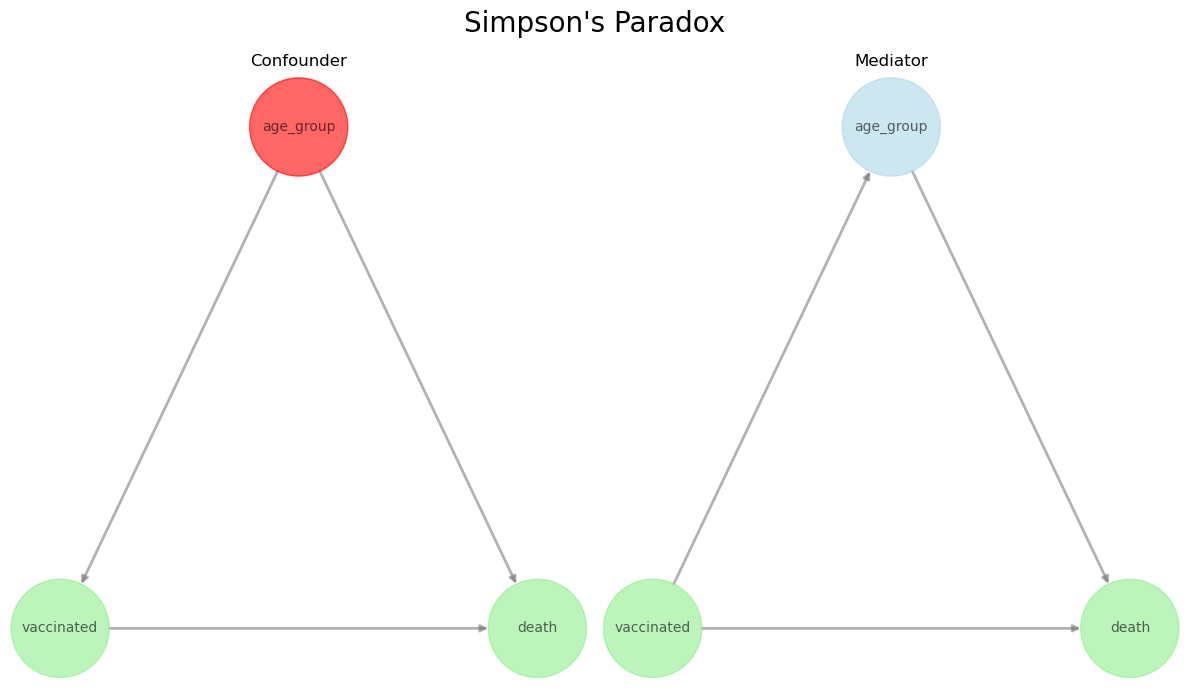

In [9]:
# %%
# Declaring options for drawing DAGs
options = {
    "with_labels": True,
    "node_size": 5000,
    "font_size": 10,
    "width": 2,
    "edge_color": "gray",
    "alpha": 0.6}

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
plt.suptitle("Simpson's Paradox", fontsize=20)
nx.draw(dag, pos=nx.planar_layout(dag),
        node_color=['lightgreen', 'lightgreen', 'red'], ax=ax1,
        **options)
nx.draw(alternative_dag, pos=nx.planar_layout(alternative_dag),
        node_color=['lightgreen', 'lightgreen', 'lightblue'], ax=ax2,
        **options)
ax1.set_title("Confounder")
ax2.set_title("Mediator")
plt.tight_layout()
plt.show()

 Use back-door formula for computing an adjusted effect

In [10]:
# %%
# Fraction of people being under 50
prob_under50 = data.query("age_group == 'under 50'").shape[0] / data.shape[0]
# Fraction of people being over 50
prob_over50 = data.query("age_group == '50 +'").shape[0] / data.shape[0]
# Adjusted probability of death for vaccinated
prob_death_vaccinated_adjusted = prob_death_vaccinated_under50 * prob_under50 \
    + prob_death_vaccinated_over50 * prob_over50
# Adjusted probability of death for unvaccinated
prob_death_unvaccinated_adjusted = prob_death_unvaccinated_under50 * \
    prob_under50 + prob_death_unvaccinated_over50 * prob_over50
# Overall effect
adjusted_effect = prob_death_vaccinated_adjusted - \
    prob_death_unvaccinated_adjusted

print(f"Adjusted P(D=1|V=1) = {prob_death_vaccinated_adjusted: .4%}\n",
      f"Adjusted P(D=1|V=0) = {prob_death_unvaccinated_adjusted: .4%}\n",
      f"Adjusted effect of vaccination is: {adjusted_effect * 100} p.p.",
      sep="")


Adjusted P(D=1|V=1) =  0.2138%
Adjusted P(D=1|V=0) =  0.7121%
Adjusted effect of vaccination is: -0.4982154745528143 p.p.


 Let's use DoWhy to solve the problem

In [11]:
# %%
# Binary encoding
data_encoded = pd.DataFrame(columns=["vaccinated", "age_group", "death"])
data_encoded["death"] = data["outcome"].map({"survived": 0, "death": 1})
data_encoded["vaccinated"] = data["vaccine_status"].map({"unvaccinated": 0,
                                                         "vaccinated": 1})
data_encoded["age_group"] = data["age_group"].map({"under 50": 0, "50 +": 1})

In [12]:
# %%
# Creating a CausalModel object for identification
model = CausalModel(data=data_encoded, treatment="vaccinated",
                    outcome="death", common_causes="age_group")
estimand = model.identify_effect()

In [13]:
# %%
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
─────────────(E[death|age_group])
d[vaccinated]                    
Estimand assumption 1, Unconfoundedness: If U→{vaccinated} and U→death then P(death|vaccinated,age_group,U) = P(death|vaccinated,age_group)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [14]:
# %%
print("The backdoor variable is:", estimand.get_backdoor_variables())
# Estimating ATE by inverse probability weighting with stabilised weights
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name="backdoor.propensity_score_weighting",
    method_params={"weighting_scheme": "ips_stabilized_weight"})
print(estimate.value * 100, "p.p.")

The backdoor variable is: ['age_group']
propensity_score_weighting
-0.49758533171532443 p.p.


 What if age_group is not a confounder? It would imply that we believe

 age_group is not a common cause of the treatment and the outcome. In general,

 such a variable can either be removed if we think it doesn't play a role in

 any causal paths, or it can be specified as a mediator/moderator.

In [15]:
# %%
# Specify the causal graph explicitly
alternative_causal_graph = """
        digraph {
            vaccinated -> age_group;
            vaccinated -> death;
            age_group -> death;
        }
"""

In [16]:
# %%
# Repeat as above
alternative_model = CausalModel(data=data_encoded, treatment="vaccinated",
                                outcome="death",
                                graph=alternative_causal_graph)
alternative_estimand = alternative_model.identify_effect()
print(alternative_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                
─────────────(E[death])
d[vaccinated]          
Estimand assumption 1, Unconfoundedness: If U→{vaccinated} and U→death then P(death|vaccinated,,U) = P(death|vaccinated,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [17]:
# %%
# No backdoor variables
print("The backdoor variable is:",
      alternative_estimand.get_backdoor_variables())

The backdoor variable is: []


In [18]:
# %%
alternative_estimate = alternative_model.estimate_effect(
    identified_estimand=alternative_estimand,
    method_name="backdoor.generalized_linear_model",
    method_params={"glm_family": sm.families.Binomial()})
print(alternative_estimate.value * 100, "p.p.")

generalized_linear_model
0.24321894171401007 p.p.


 To summarise: If there is a confounder (a variable that affects both the

 treatment and the outcome), we should adjust for it to ensure identification.

 If a variable is not a confounder, we shouldn't adjust for it unless we want

 to estimate the direct effect (if it's a mediator).